# generate-DE-test-figures
2.8.23

Here we're grabbing the post-imputation reconstructions from `DE-test-mf.py` and `DE-test-simple.py`, conducting the DE tests and generating Precision Recall curves. 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

# import my modules
sys.path.append('../../../../../bin/')
import util_functions
#import intermediate_plots

# plotting templates
sns.set(context="talk", style="ticks") 
sns.set_palette("tab10")

#### Configs

In [2]:
# for determining the ground truth DE peptides
    # also the imputed DE peptides
alpha = 0.01
correction = "BH"

#### Perform the inital DE test
To get the ground truth DE peptides

In [3]:
# read in 
cond1_df = pd.read_csv(
            "../../../2022-10-31_SMTG_data/data/SMTG-ADD-quants.csv")
cond2_df = pd.read_csv(
            "../../../2022-10-31_SMTG_data/data/SMTG-HCF-low-quants.csv")

# get the list of peptide IDs, or rather transition group IDs
    # these will be the same for the two datasets
peptide_ids = np.array(cond1_df["pids"])

# now remove the peptide ID columns
to_remove = ["pids"]
cond1_df = cond1_df.drop(to_remove, axis=1)
cond2_df = cond2_df.drop(to_remove, axis=1)

# convert to numpy arrays
cond1_quants = np.array(cond1_df)
cond2_quants = np.array(cond2_df)

print("condition 1 quants: ", cond1_quants.shape)
print("condition 2 quants: ", cond2_quants.shape)

# get ground truth DE peptides
reject_null_gt, pvals_correct = \
            util_functions.find_DE_peptides(
                                cond1_quants, 
                                cond2_quants, 
                                correction, 
                                alpha
            )
DE_peptides_gt = list(peptide_ids[reject_null_gt])

# this is for eventually separating the reconstructed matrices 
    # into normal and tumor matrices
cols_cutoff = cond1_quants.shape[1]

condition 1 quants:  (32614, 9)
condition 2 quants:  (32614, 9)


***

## MNAR workflow

#### Read in the reconstructed dataframes

In [4]:
nmf_recon = pd.read_csv("../data/nmf-recon-mnar.csv")
knn_recon = pd.read_csv("../data/knn-recon-mnar.csv")
mf_recon = pd.read_csv("../data/missForest-recon-mnar.csv")
sample_min_recon = pd.read_csv("../data/sample-min-recon-mnar.csv")
gsample_recon = pd.read_csv("../data/gsample-recon-mnar.csv")
noimp_recon = pd.read_csv("../data/noimpute-recon-mnar.csv")

nmf_recon = np.array(nmf_recon)
knn_recon = np.array(knn_recon)
mf_recon = np.array(mf_recon)
sample_min_recon = np.array(sample_min_recon)
gsample_recon = np.array(gsample_recon)
noimp_recon = np.array(noimp_recon)

#### Separate the recon matrices into the two experimental conditions

In [5]:
# for the NMF model 
cond1_recon_nmf = nmf_recon[:,0:cols_cutoff]
cond2_recon_nmf = nmf_recon[:,cols_cutoff:]

# for the kNN model 
cond1_recon_knn = knn_recon[:,0:cols_cutoff]
cond2_recon_knn = knn_recon[:,cols_cutoff:]

# for missForest
cond1_recon_mf = mf_recon[:,0:cols_cutoff]
cond2_recon_mf = mf_recon[:,cols_cutoff:]

# for min impute
cond1_recon_min = sample_min_recon[:,0:cols_cutoff]
cond2_recon_min = sample_min_recon[:,cols_cutoff:]

# for random sample impute
cond1_recon_std = gsample_recon[:,0:cols_cutoff]
cond2_recon_std = gsample_recon[:,cols_cutoff:]

# for no impute
cond1_noimp = noimp_recon[:,0:cols_cutoff]
cond2_noimp = noimp_recon[:,cols_cutoff:]

#### Get the corrected p-values for each reconstruction

In [6]:
r, cp_vals_nmf = util_functions.find_DE_peptides(
                        cond1_recon_nmf, cond2_recon_nmf, 
                        correction, alpha_=alpha)
r, cp_vals_knn = util_functions.find_DE_peptides(
                        cond1_recon_knn, cond2_recon_knn, 
                        correction, alpha_=alpha)
r, cp_vals_mf = util_functions.find_DE_peptides(
                      cond1_recon_mf, cond2_recon_mf, 
                      correction, alpha_=alpha)
r, cp_vals_min = util_functions.find_DE_peptides(
                        cond1_recon_min, cond2_recon_min, 
                        correction, alpha_=alpha)
r, cp_vals_std = util_functions.find_DE_peptides(
                        cond1_recon_std, cond2_recon_std, 
                        correction, alpha_=alpha)
r, cp_vals_noimp = util_functions.find_DE_peptides(
                        cond1_noimp, cond2_noimp, 
                        correction, alpha_=alpha)

/net/noble/vol2/home/lincolnh/.local/lib/python3.7/site-packages/scipy/stats/mstats_basic.py:1077: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
../../../../../bin/util_functions.py:1040: UserWarning: Warning: converting a masked element to nan.
  checkf = float(t_stat)


#### Get the ground truth DE labels

In [7]:
# the ground truth labels. True means DE peptide, False means not
gt_labels = reject_null_gt.astype(float)

#### Get the DE probabilities for each model 

In [8]:
# get the DE probabilities, for each model 
prob_true_nmf = 1 - cp_vals_nmf
prob_true_knn = 1 - cp_vals_knn
prob_true_mf = 1 - cp_vals_mf
prob_true_min = 1 - cp_vals_min
prob_true_std = 1 - cp_vals_std
prob_true_noimp = 1 - cp_vals_noimp

#### Get the Precision Recall stats for each model 

In [9]:
# call the sklearn PR plotting function 
pr_nmf, recall_nmf, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_nmf)
pr_knn, recall_knn, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_knn)
pr_mf, recall_mf, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_mf)
pr_min, recall_min, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_min)
pr_std, recall_std, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_std)
pr_noimp, recall_noimp, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_noimp)

#### Get the AUCs

In [10]:
# get the AUCs
nmf_auc = np.around(auc(recall_nmf, pr_nmf), 2)
knn_auc = np.around(auc(recall_knn, pr_knn), 2)
mf_auc = np.around(auc(recall_mf, pr_mf), 2)
min_auc = np.around(auc(recall_min, pr_min), 2)
std_auc = np.around(auc(recall_std, pr_std), 2)
noimp_auc = np.around(auc(recall_noimp, pr_noimp), 2)

#### Plot!

Text(0.5, 1.0, 'MNAR')

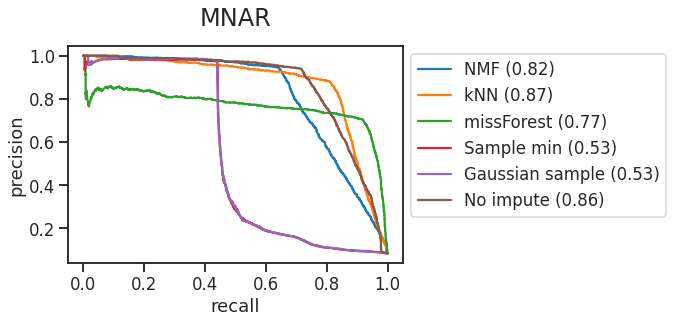

In [11]:
plt.figure()

plt.plot(
    recall_nmf, pr_nmf, label="NMF (" + str(nmf_auc) + ")")
plt.plot(
  recall_knn, pr_knn, label="kNN (" + str(knn_auc) + ")")
plt.plot(
    recall_mf, pr_mf, 
    label="missForest (" + str(mf_auc) + ")")
plt.plot(
    recall_min, pr_min, 
    label="Sample min (" + str(min_auc) + ")")
plt.plot(
    recall_std, pr_std, 
    label="Gaussian sample (" + str(std_auc) + ")")
plt.plot(
    recall_noimp, pr_noimp, 
    label="No impute (" + str(noimp_auc) + ")")

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("MNAR", pad=20, size=24)

# plt.savefig(
#     "logs/DE-experiment-MNAR.png", dpi=250, bbox_inches="tight"
# )

***

## MCAR workflow

#### Read in the reconstructed matrices

In [12]:
nmf_recon_mcar = pd.read_csv("../data/nmf-recon-mcar.csv")
knn_recon_mcar = pd.read_csv("../data/knn-recon-mcar.csv")
mf_recon_mcar = pd.read_csv("../data/missForest-recon-mcar.csv")
sample_min_recon_mcar = pd.read_csv("../data/sample-min-recon-mcar.csv")
gsample_recon_mcar = pd.read_csv("../data/gsample-recon-mcar.csv")
noimp_recon_mcar = pd.read_csv("../data/noimpute-recon-mcar.csv")

nmf_recon_mcar = np.array(nmf_recon_mcar)
knn_recon_mcar = np.array(knn_recon_mcar)
mf_recon_mcar = np.array(mf_recon_mcar)
sample_min_recon_mcar = np.array(sample_min_recon_mcar)
gsample_recon_mcar = np.array(gsample_recon_mcar)
noimp_recon_mcar = np.array(noimp_recon_mcar)

#### Separate into the two experimental conditions

In [13]:
# for the NMF model 
cond1_recon_nmf_mcar = nmf_recon_mcar[:,0:cols_cutoff]
cond2_recon_nmf_mcar = nmf_recon_mcar[:,cols_cutoff:]

# for the kNN model 
cond1_recon_knn_mcar = knn_recon_mcar[:,0:cols_cutoff]
cond2_recon_knn_mcar = knn_recon_mcar[:,cols_cutoff:]

# for missForest
cond1_recon_mf_mcar = mf_recon_mcar[:,0:cols_cutoff]
cond2_recon_mf_mcar = mf_recon_mcar[:,cols_cutoff:]

# for min impute
cond1_recon_min_mcar = sample_min_recon_mcar[:,0:cols_cutoff]
cond2_recon_min_mcar = sample_min_recon_mcar[:,cols_cutoff:]

# for random sample impute
cond1_recon_std_mcar = gsample_recon_mcar[:,0:cols_cutoff]
cond2_recon_std_mcar = gsample_recon_mcar[:,cols_cutoff:]

# for no impute
cond1_noimp_mcar = noimp_recon_mcar[:,0:cols_cutoff]
cond2_noimp_mcar = noimp_recon_mcar[:,cols_cutoff:]

#### Get the corrected p-values for each reconstruction

In [14]:
r, cp_vals_nmf_mcar = util_functions.find_DE_peptides(
                        cond1_recon_nmf_mcar, cond2_recon_nmf_mcar, 
                        correction, alpha_=alpha)
r, cp_vals_knn_mcar = util_functions.find_DE_peptides(
                        cond1_recon_knn_mcar, cond2_recon_knn_mcar, 
                        correction, alpha_=alpha)
r, cp_vals_mf_mcar = util_functions.find_DE_peptides(
                      cond1_recon_mf_mcar, cond2_recon_mf_mcar, 
                      correction, alpha_=alpha)
r, cp_vals_min_mcar = util_functions.find_DE_peptides(
                        cond1_recon_min_mcar, cond2_recon_min_mcar, 
                        correction, alpha_=alpha)
r, cp_vals_std_mcar = util_functions.find_DE_peptides(
                        cond1_recon_std_mcar, cond2_recon_std_mcar, 
                        correction, alpha_=alpha)
r, cp_vals_noimp_mcar = util_functions.find_DE_peptides(
                        cond1_noimp_mcar, cond2_noimp_mcar, 
                        correction, alpha_=alpha)

../../../../../bin/util_functions.py:1040: UserWarning: Warning: converting a masked element to nan.
  checkf = float(t_stat)


#### Get the DE probabilities for each impute method

In [15]:
prob_true_nmf_mcar = 1 - cp_vals_nmf_mcar
prob_true_knn_mcar = 1 - cp_vals_knn_mcar
prob_true_mf_mcar = 1 - cp_vals_mf_mcar
prob_true_min_mcar = 1 - cp_vals_min_mcar
prob_true_std_mcar = 1 - cp_vals_std_mcar
prob_true_noimp_mcar = 1 - cp_vals_noimp_mcar

#### Get the Precision Recall stats for each method

In [16]:
# call the sklearn PR plotting function 
pr_nmf_mcar, recall_nmf_mcar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_nmf_mcar)
pr_knn_mcar, recall_knn_mcar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_knn_mcar)
pr_mf_mcar, recall_mf_mcar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_mf_mcar)
pr_min_mcar, recall_min_mcar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_min_mcar)
pr_std_mcar, recall_std_mcar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_std_mcar)
pr_noimp_mcar, recall_noimp_mcar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_noimp_mcar)

#### Get the AUCs

In [17]:
nmf_auc_mcar = np.around(auc(recall_nmf_mcar, pr_nmf_mcar), 2)
knn_auc_mcar = np.around(auc(recall_knn_mcar, pr_knn_mcar), 2)
mf_auc_mcar = np.around(auc(recall_mf_mcar, pr_mf_mcar), 2)
min_auc_mcar = np.around(auc(recall_min_mcar, pr_min_mcar), 2)
std_auc_mcar = np.around(auc(recall_std_mcar, pr_std_mcar), 2)
noimp_auc_mcar = np.around(auc(recall_noimp_mcar, pr_noimp_mcar), 2)

#### Plot

Text(0.5, 1.0, 'MNAR')

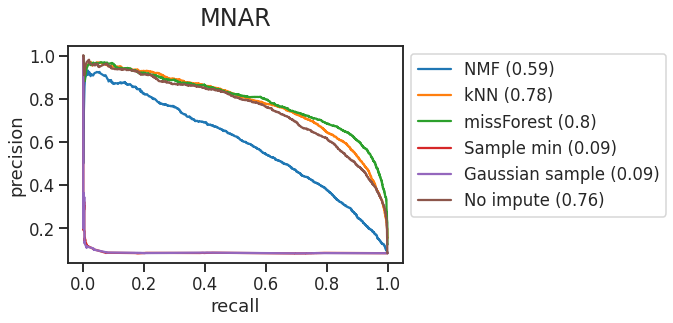

In [18]:
plt.figure()

plt.plot(
    recall_nmf_mcar, pr_nmf_mcar, label="NMF (" + str(nmf_auc_mcar) + ")")
plt.plot(
  recall_knn_mcar, pr_knn_mcar, label="kNN (" + str(knn_auc_mcar) + ")")
plt.plot(
    recall_mf_mcar, pr_mf_mcar, 
    label="missForest (" + str(mf_auc_mcar) + ")")
plt.plot(
    recall_min_mcar, pr_min_mcar, 
    label="Sample min (" + str(min_auc_mcar) + ")")
plt.plot(
    recall_std_mcar, pr_std_mcar, 
    label="Gaussian sample (" + str(std_auc_mcar) + ")")
plt.plot(
    recall_noimp_mcar, pr_noimp_mcar, 
    label="No impute (" + str(noimp_auc_mcar) + ")")

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("MNAR", pad=20, size=24)

# plt.savefig(
#     "logs/DE-experiment-MNAR.png", dpi=250, bbox_inches="tight"
# )

***

## Plot MNAR and MCAR side-by-side

#### First attempt

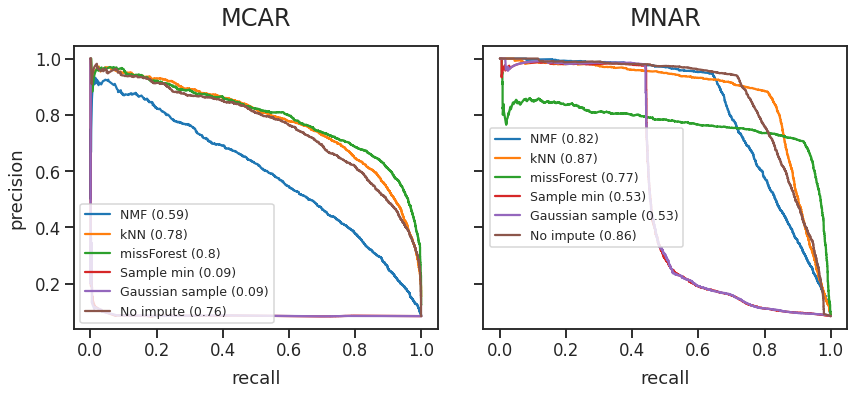

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,5), sharey=True, sharex=True) 
fig.tight_layout()

axes[0].plot(
    recall_nmf_mcar, pr_nmf_mcar, label="NMF (" + str(nmf_auc_mcar) + ")")
axes[0].plot(
  recall_knn_mcar, pr_knn_mcar, label="kNN (" + str(knn_auc_mcar) + ")")
axes[0].plot(
    recall_mf_mcar, pr_mf_mcar, 
    label="missForest (" + str(mf_auc_mcar) + ")")
axes[0].plot(
    recall_min_mcar, pr_min_mcar, 
    label="Sample min (" + str(min_auc_mcar) + ")")
axes[0].plot(
    recall_std_mcar, pr_std_mcar, 
    label="Gaussian sample (" + str(std_auc_mcar) + ")")
axes[0].plot(
    recall_noimp_mcar, pr_noimp_mcar, 
    label="No impute (" + str(noimp_auc_mcar) + ")")
axes[0].set_xlabel("recall", labelpad=10)
axes[0].set_ylabel("precision", labelpad=10)
axes[0].set_title("MCAR", pad=20, size=24)
axes[0].legend(loc="best", fontsize="x-small")

axes[1].plot(
    recall_nmf, pr_nmf, label="NMF (" + str(nmf_auc) + ")")
axes[1].plot(
  recall_knn, pr_knn, label="kNN (" + str(knn_auc) + ")")
axes[1].plot(
    recall_mf, pr_mf, 
    label="missForest (" + str(mf_auc) + ")")
axes[1].plot(
    recall_min, pr_min, 
    label="Sample min (" + str(min_auc) + ")")
axes[1].plot(
    recall_std, pr_std, 
    label="Gaussian sample (" + str(std_auc) + ")")
axes[1].plot(
    recall_noimp, pr_noimp, 
    label="No impute (" + str(noimp_auc) + ")")
axes[1].set_xlabel("recall", labelpad=10)
axes[1].set_ylabel("")
axes[1].set_title("MNAR", pad=20, size=24)
axes[1].legend(loc="best", fontsize="x-small")

# combine the legend handles and labels
# handles0, labels0 = axes[0].get_legend_handles_labels()
# handles1, labels1 = axes[1].get_legend_handles_labels()

# handles_comb = handles0 + handles1
# labels_comb = labels0 + labels1

# fig.legend(handles_comb, labels_comb, loc='upper center')

# plt.savefig(
#     "logs/DE-experiment-multipanel.png", dpi=250, bbox_inches="tight"
# )

#### Messing around with the legends
Don't display either AUC value

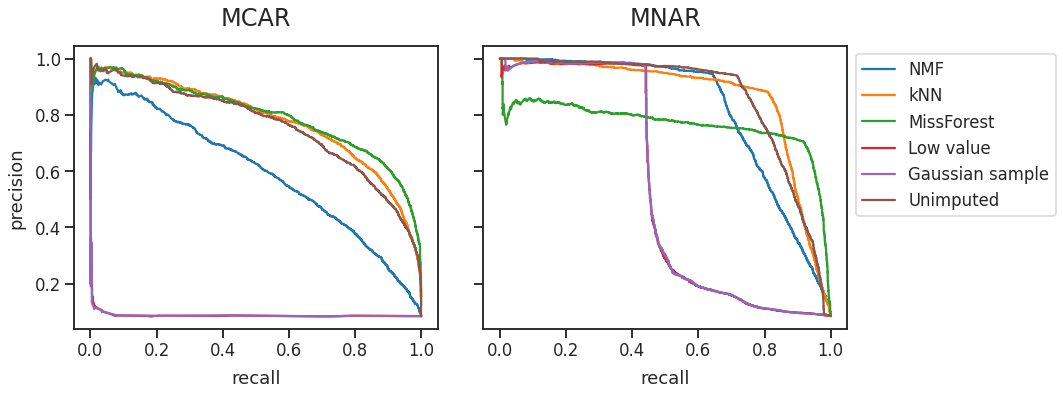

In [25]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,5), sharey=True, sharex=True) 
fig.tight_layout()

axes[0].plot(
    recall_nmf_mcar, pr_nmf_mcar)
axes[0].plot(
  recall_knn_mcar, pr_knn_mcar)
axes[0].plot(
    recall_mf_mcar, pr_mf_mcar)
axes[0].plot(
    recall_min_mcar, pr_min_mcar)
axes[0].plot(
    recall_std_mcar, pr_std_mcar)
axes[0].plot(
    recall_noimp_mcar, pr_noimp_mcar)
axes[0].set_xlabel("recall", labelpad=10)
axes[0].set_ylabel("precision", labelpad=10)
axes[0].set_title("MCAR", pad=20, size=24)

axes[1].plot(
    recall_nmf, pr_nmf, label="NMF")
axes[1].plot(
  recall_knn, pr_knn, label="kNN")
axes[1].plot(
    recall_mf, pr_mf, 
    label="MissForest")
axes[1].plot(
    recall_min, pr_min, 
    label="Low value")
axes[1].plot(
    recall_std, pr_std, 
    label="Gaussian sample")
axes[1].plot(
    recall_noimp, pr_noimp, 
    label="Unimputed")
axes[1].set_xlabel("recall", labelpad=10)
axes[1].set_ylabel("")
axes[1].set_title("MNAR", pad=20, size=24)
axes[1].legend(bbox_to_anchor=(1,1))

# plt.savefig(
#     "../logs/DE-experiment-multipanel11.png", dpi=250, bbox_inches="tight"
# )

#### Display both AUC values in the legend

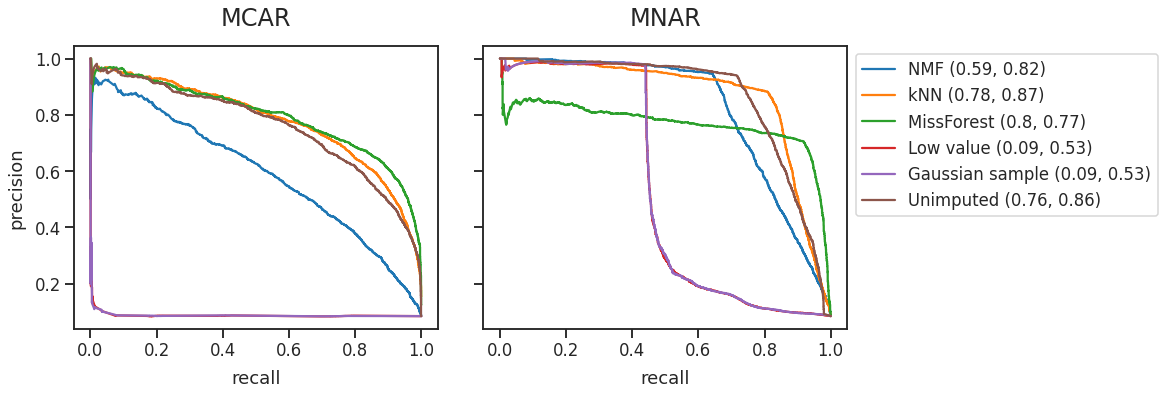

In [22]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,5), sharey=True, sharex=True) 
fig.tight_layout()

axes[0].plot(
    recall_nmf_mcar, pr_nmf_mcar)
axes[0].plot(
  recall_knn_mcar, pr_knn_mcar)
axes[0].plot(
    recall_mf_mcar, pr_mf_mcar)
axes[0].plot(
    recall_min_mcar, pr_min_mcar)
axes[0].plot(
    recall_std_mcar, pr_std_mcar)
axes[0].plot(
    recall_noimp_mcar, pr_noimp_mcar)
axes[0].set_xlabel("recall", labelpad=10)
axes[0].set_ylabel("precision", labelpad=10)
axes[0].set_title("MCAR", pad=20, size=24)

axes[1].plot(
    recall_nmf, pr_nmf, label="NMF (" + str(nmf_auc_mcar) + ", " + str(nmf_auc) + ")")
axes[1].plot(
  recall_knn, pr_knn, label="kNN (" + str(knn_auc_mcar) + ", " + str(knn_auc) + ")")
axes[1].plot(
    recall_mf, pr_mf, 
    label="MissForest (" + str(mf_auc_mcar) + ", " + str(mf_auc) + ")")
axes[1].plot(
    recall_min, pr_min, 
    label="Low value ("+ str(min_auc_mcar) + ", " + str(min_auc) + ")")
axes[1].plot(
    recall_std, pr_std, 
    label="Gaussian sample ("+ str(std_auc_mcar) + ", " + str(std_auc) + ")")
axes[1].plot(
    recall_noimp, pr_noimp, 
    label="Unimputed ("+ str(noimp_auc_mcar) + ", " + str(noimp_auc) + ")")
axes[1].set_xlabel("recall", labelpad=10)
axes[1].set_ylabel("")
axes[1].set_title("MNAR", pad=20, size=24)
axes[1].legend(bbox_to_anchor=(1,1))

# plt.savefig(
#     "logs/DE-experiment-multipanel1.png", dpi=250, bbox_inches="tight"
# )